# Group project

By delivering this notebook, we confirm that the group project was developed by the following students.

## Student 1: Rômulo, 50530
## Student 2: Maria, 50465


The group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


## Colab setup

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [390]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar -y
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')



## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory the files in the following link: [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing).

## Initialization

Import libraries. 

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors

plt.style.use('seaborn')

print(pyspark.__version__)


3.1.2


Let's start spark session and set *log* level to ERROR.

In [384]:

spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.


In [10]:
# Comment the following 
flightsF = "sample.csv"
# flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
#flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/group2122/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/group2122/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/group2122/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")


## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [11]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-07-01|        XE|             5

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of aurport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [12]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)


+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


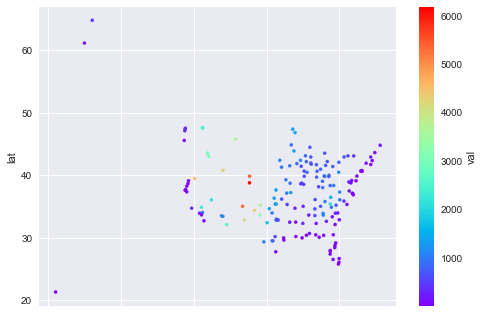

In [13]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter")


### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [14]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)


+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [10]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))



+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|    4826658|
|        NK|     588574|
|        AA|    6682161|
|        NW|     292400|
|        EV|    4726445|
|        B6|    2483969|
|        DL|    7841880|
|        OO|    6263052|
|        F9|     903218|
|        YV|    1063558|
|        US|    2657286|
|        MQ|    3216260|
|        OH|     577060|
|        HA|     744991|
|        XE|    1105864|
|        G4|      96221|
|        YX|     316090|
|        AS|    1660539|
|        FL|    1218389|
|        CO|     740498|
+----------+-----------+
only showing top 20 rows

Runtime = 104.44895696640015


* Execution time for sample.csv: <b>6.0630</b>
* Execution time for complete.csv: <b>105.2344</b>

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: <b>10.7719</b>
* Execution time for complete.csv: <b>199.7952</b>


### Code: Pandas library

In [22]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


             FL_DATE
OP_CARRIER          
9E           1066251
AA           6682161
AS           1660539
B6           2483969
CO            740498
DL           7841880
EV           4726445
F9            903218
FL           1218389
G4             96221
HA            744991
MQ           3216260
NK            588574
NW            292400
OH            577060
OO           6263052
UA           4826658
US           2657286
VX            389060
WN          12096540
XE           1105864
YV           1063558
YX            316090
Runtime = 1502.589280128479


* Execution time for sample.csv: <b>27.5704</b>
* Execution time for complete.csv: <b>1502.5893</b>

**Discuss the results you have obtained:**
Using Spark to read dataframes and perform dataframe queries is significantly faster than Pandas as Pandas dataframes are not distributed whereas Spark dataframes are. This means that for large amounts of data, such as with the flights dataframes, one benefits from parallel processing using Spark which translates into faster processing of data. 

## Problem 1 [4 points]

In this first problem, you should compute a set of statistics on the data.


### Top-20 airports with more flights (include the name of the airport)

In [10]:
dfTop20AirportsDepartures = spark.sql("SELECT f.ORIGIN AS CODE, a.name AS NAME FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code")
print("Top 20 airports with more flights departing")
dfTop20AirportsDepartures = dfTop20AirportsDepartures.toPandas()
groupedDfTop20AirportsDepartures = dfTop20AirportsDepartures.groupby(["CODE", "NAME"]).size().reset_index(name="N_OF_DEPARTURES")
print(groupedDfTop20AirportsDepartures.sort_values(by=["N_OF_DEPARTURES"], ascending=False)[:20])

dfTop20AirportsArriving = spark.sql("SELECT f.DEST AS CODE, a.name AS NAME FROM flights f INNER JOIN airports a ON f.DEST = a.iata_code")
print("\n\nTop 20 airports with more flights arriving")
dfTop20AirportsArriving = dfTop20AirportsArriving.toPandas()
groupedDfTop20AirportsArriving = dfTop20AirportsArriving.groupby(["CODE", "NAME"]).size().reset_index(name="N_OF_ARRIVALS")
print(groupedDfTop20AirportsArriving.sort_values(by=["N_OF_ARRIVALS"], ascending=False)[:20])


Top 20 airports with more flights departing


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


    CODE                                               NAME  N_OF_DEPARTURES
21   ATL   Hartsfield Jackson Atlanta International Airport           147589
256  ORD               Chicago O'Hare International Airport           115049
95   DFW            Dallas Fort Worth International Airport            95641
94   DEN                       Denver International Airport            89928
195  LAX                  Los Angeles International Airport            83685
271  PHX           Phoenix Sky Harbor International Airport            63831
167  IAH       George Bush Intercontinental Houston Airport            63593
316  SFO                San Francisco International Airport            63054
193  LAS                     McCarran International Airport            55333
241  MSP  Minneapolis-St Paul International/Wold-Chamber...            51510
103  DTW          Detroit Metropolitan Wayne County Airport            50049
74   CLT            Charlotte Douglas International Airport            49649

/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


    CODE                                               NAME  N_OF_ARRIVALS
21   ATL   Hartsfield Jackson Atlanta International Airport         147555
256  ORD               Chicago O'Hare International Airport         115041
95   DFW            Dallas Fort Worth International Airport          95613
94   DEN                       Denver International Airport          89927
195  LAX                  Los Angeles International Airport          83684
271  PHX           Phoenix Sky Harbor International Airport          63830
167  IAH       George Bush Intercontinental Houston Airport          63613
316  SFO                San Francisco International Airport          63041
193  LAS                     McCarran International Airport          55340
241  MSP  Minneapolis-St Paul International/Wold-Chamber...          51461
103  DTW          Detroit Metropolitan Wayne County Airport          50035
74   CLT            Charlotte Douglas International Airport          49602
314  SEA               Se

### Top-20 days with more flights

In [19]:
dfTop20DaysWithMoreFlights = spark.sql("SELECT FL_DATE AS DATE, COUNT(*) as N_OF_FLIGHTS from flights GROUP BY FL_DATE ORDER BY COUNT(*) DESC LIMIT 20")
print("Top 20 days with more flights")
print(dfTop20DaysWithMoreFlights.toPandas())

Top 20 days with more flights


/opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


          DATE  N_OF_FLIGHTS
0   2018-07-13         22022
1   2018-07-12         21966
2   2018-07-09         21956
3   2018-07-11         21736
4   2018-07-10         21628
5   2018-07-15         21262
6   2018-07-08         21251
7   2018-07-06         20393
8   2018-07-01         19985
9   2018-07-02         19727
10  2018-07-05         19649
11  2009-07-10         19425
12  2009-07-02         19399
13  2013-07-12         19391
14  2009-07-09         19377
15  2009-07-06         19362
16  2013-07-08         19361
17  2009-07-13         19356
18  2013-07-15         19354
19  2013-07-11         19349


### Periods with more flights: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [36]:
print("Periods (morning, midday and evening) and their number of scheduled flights")

dfMorningFlights = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlights.show()

dfMiddayFlights = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlights.show()

dfEveningFlights = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlights.show()


print("Periods (morning, midday and evening) and their number of flights that actually departed")

dfMorningFlights = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '00:00' AND DEP_TIME <= '11:59'")
dfMorningFlights.show()

dfMiddayFlights = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '12:00' AND DEP_TIME <= '17:59'")
dfMiddayFlights.show()

dfEveningFlights = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS from flights WHERE DEP_TIME >= '18:00' AND DEP_TIME <= '23:59'")
dfEveningFlights.show()


Periods (morning, midday and evening) and their number of scheduled flights
+-------+------------+
|Morning|N_OF_FLIGHTS|
+-------+------------+
|Morning|      981231|
+-------+------------+

+------+------------+
|Midday|N_OF_FLIGHTS|
+------+------------+
|Midday|      865053|
+------+------------+

+-------+------------+
|Evening|N_OF_FLIGHTS|
+-------+------------+
|Evening|      517320|
+-------+------------+

Periods (morning, midday and evening) and their number of flights that actually departed
+-------+------------+
|Morning|N_OF_FLIGHTS|
+-------+------------+
|Morning|      969080|
+-------+------------+

+------+------------+
|Midday|N_OF_FLIGHTS|
+------+------------+
|Midday|      824862|
+------+------------+

+-------+------------+
|Evening|N_OF_FLIGHTS|
+-------+------------+
|Evening|      539024|
+-------+------------+



### Top-20 airports with longer delays

In [66]:
dfTop20AirportsLongerDepartureDelays = spark.sql("SELECT f.ORIGIN AS CODE, a.name AS NAME, f.DEP_DELAY AS DEPARTURE_DELAY FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code")
dfTop20AirportsLongerDepartureDelays = dfTop20AirportsLongerDepartureDelays.toPandas()
groupedDfTop20AirportsLongerDepartureDelays = dfTop20AirportsLongerDepartureDelays.groupby(["CODE", "NAME"]).sum()
groupedDfTop20AirportsLongerDepartureDelays = groupedDfTop20AirportsLongerDepartureDelays.join(groupedDfTop20AirportsDepartures.set_index(["CODE", "NAME"]))
groupedDfTop20AirportsLongerDepartureDelays["AVG_DELAY"] = groupedDfTop20AirportsLongerDepartureDelays["DEPARTURE_DELAY"] / groupedDfTop20AirportsLongerDepartureDelays["N_OF_DEPARTURES"]
print("Top 20 airports with longer average delays for departures")
groupedDfTop20AirportsLongerDepartureDelaysSorted = groupedDfTop20AirportsLongerDepartureDelays.sort_values(by=["AVG_DELAY"], ascending=False)[:20]
print(groupedDfTop20AirportsLongerDepartureDelaysSorted["AVG_DELAY"])

dfTop20AirportsLongerArrivalsDelays = spark.sql("SELECT f.DEST AS CODE, a.name AS NAME, f.ARR_DELAY AS ARRIVAL_DELAY FROM flights f INNER JOIN airports a ON f.DEST = a.iata_code")
dfTop20AirportsLongerArrivalsDelays = dfTop20AirportsLongerArrivalsDelays.toPandas()
groupedDfTop20AirportsLongerArrivalsDelays = dfTop20AirportsLongerArrivalsDelays.groupby(["CODE", "NAME"]).sum()
groupedDfTop20AirportsLongerArrivalsDelays = groupedDfTop20AirportsLongerArrivalsDelays.join(groupedDfTop20AirportsArriving.set_index(["CODE", "NAME"]))
groupedDfTop20AirportsLongerArrivalsDelays["AVG_DELAY"] = groupedDfTop20AirportsLongerArrivalsDelays["ARRIVAL_DELAY"] / groupedDfTop20AirportsLongerArrivalsDelays["N_OF_ARRIVALS"]
print("\n\nTop 20 airports with longer average delays for arrivals")
groupedDfTop20AirportsLongerArrivalsDelaysSorted = groupedDfTop20AirportsLongerArrivalsDelays.sort_values(by=["AVG_DELAY"], ascending=False)[:20]
print(groupedDfTop20AirportsLongerArrivalsDelaysSorted["AVG_DELAY"])


Top 20 airports with longer average delays for departures
CODE  NAME                                          
HGR   Hagerstown Regional Richard A Henson Field        62.333333
IFP   Laughlin Bullhead International Airport           40.800000
OGD   Ogden Hinckley Airport                            38.250000
UST   Northeast Florida Regional Airport                34.500000
BLV   Scott AFB/Midamerica Airport                      33.529412
HYA   Barnstable Municipal Boardman Polando Field       33.293333
CEC   Jack Mc Namara Field Airport                      32.753555
LCK   Rickenbacker International Airport                30.558824
PSM   Portsmouth International at Pease Airport         29.312500
SLN   Salina Municipal Airport                          29.162162
OTH   Southwest Oregon Regional Airport                 25.108974
MVY   Martha's Vineyard Airport                         24.548780
CKB   North Central West Virginia Airport               24.189189
GCK   Garden City Regional Airp

### Top 10 carriers with longer delays

In [86]:
dfTop10CarriersWithLongerDelaysDepartures = spark.sql("SELECT OP_CARRIER, COUNT(*) AS N_OF_FLIGHTS, SUM(DEP_DELAY) AS TOTAL_DELAY_DEPARTURES, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DELAY_DEPARTURES FROM flights GROUP BY OP_CARRIER ORDER BY AVG_DELAY_DEPARTURES DESC LIMIT 10")
print("Top 10 carriers with longer average delay for departures")
dfTop10CarriersWithLongerDelaysDepartures.show()

dfTop10CarriersWithLongerDelaysArrivals = spark.sql("SELECT OP_CARRIER, COUNT(*) AS N_OF_FLIGHTS, SUM(ARR_DELAY) AS TOTAL_DELAY_ARRIVALS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_DELAY_ARRIVALS FROM flights GROUP BY OP_CARRIER ORDER BY AVG_DELAY_ARRIVALS DESC LIMIT 10")
print("\n\nTop 10 carriers with longer average delay for arrivals")
dfTop10CarriersWithLongerDelaysArrivals.show()


Top 10 carriers with longer average delay for departures
+----------+------------+----------------------+--------------------+
|OP_CARRIER|N_OF_FLIGHTS|TOTAL_DELAY_DEPARTURES|AVG_DELAY_DEPARTURES|
+----------+------------+----------------------+--------------------+
|        G4|        5123|                103978|  20.296310755416748|
|        B6|       97885|               1609586|  16.443643050518464|
|        UA|      192622|               3083528|  16.008181827620938|
|        EV|      185522|               2945287|  15.875675122087946|
|        F9|       36190|                571738|  15.798231555678365|
|        VX|       15862|                236575|   14.91457571554659|
|        NK|       25439|                355062|  13.957388262117222|
|        WN|      465495|               5829462|  12.523146328102342|
|        AA|      266003|               3326410|  12.505159716243801|
|        FL|       43105|                521860|  12.106716158218305|
+----------+------------+--------

### Longer delays by period: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [91]:
print("Average delays by period for departure")

dfMorningFlightsDelays = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlightsDelays.show()

dfMiddayFlightsDelays = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlightsDelays.show()

dfEveningFlightsDelays = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS, (SUM(DEP_DELAY)/COUNT(*)) AS AVG_DEPARTURE_DELAY from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlightsDelays.show()

print("\n\nAverage delays by period for arrivals, according to departure time")

dfMorningFlightsDelays = spark.sql("SELECT 'Morning', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '00:00' AND CRS_DEP_TIME <= '11:59'")
dfMorningFlightsDelays.show()

dfMiddayFlightsDelays = spark.sql("SELECT 'Midday', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '12:00' AND CRS_DEP_TIME <= '17:59'")
dfMiddayFlightsDelays.show()

dfEveningFlightsDelays = spark.sql("SELECT 'Evening', COUNT(*) as N_OF_FLIGHTS, (SUM(ARR_DELAY)/COUNT(*)) AS AVG_ARRIVAL_DELAY from flights WHERE CRS_DEP_TIME >= '18:00' AND CRS_DEP_TIME <= '23:59'")
dfEveningFlightsDelays.show()


Average delays by period for departure
+-------+------------+-------------------+
|Morning|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+-------+------------+-------------------+
|Morning|      981231|   4.77306363129579|
+-------+------------+-------------------+

+------+------------+-------------------+
|Midday|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+------+------------+-------------------+
|Midday|      865053| 14.239094020828782|
+------+------------+-------------------+

+-------+------------+-------------------+
|Evening|N_OF_FLIGHTS|AVG_DEPARTURE_DELAY|
+-------+------------+-------------------+
|Evening|      517320| 19.822545039820614|
+-------+------------+-------------------+



Average delays by period for arrivals, according to departure time
+-------+------------+-----------------+
|Morning|N_OF_FLIGHTS|AVG_ARRIVAL_DELAY|
+-------+------------+-----------------+
|Morning|      981231|0.596434478731308|
+-------+------------+-----------------+

+------+------------+------------------+
|M

## Problem 2 [4 points]

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, similar but considering flights in the same week day, but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [447]:
groupedDelays = spark.sql("SELECT FL_DATE, FIRST(OP_CARRIER) AS OP_CARRIER, FIRST(ORIGIN) AS ORIGIN, FIRST(DEST) AS DEST, AVG(DEP_DELAY) AS DEP_DELAY from flights GROUP BY FL_DATE, OP_CARRIER, ORIGIN, DEST ORDER BY FL_DATE DESC")
groupedDelays.createOrReplaceTempView("grouped_delays")


In [450]:
dfDelaysMA = spark.sql("SELECT FL_DATE, FIRST(OP_CARRIER) AS OP_CARRIER, FIRST(ORIGIN) AS ORIGIN, FIRST(DEST) AS DEST, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS MovingAverageSevenDays, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 30 PRECEDING AND CURRENT ROW) AS MovingAverageThirtyDays, AVG(FIRST(DEP_DELAY)) OVER (ORDER BY FL_DATE ASC ROWS BETWEEN 365 PRECEDING AND CURRENT ROW) AS MovingAverage365Days from grouped_delays GROUP BY FL_DATE, OP_CARRIER, ORIGIN, DEST ORDER BY FL_DATE DESC")
dfDelaysMA.show(5)

+----------+----------+------+----+----------------------+-----------------------+--------------------+
|   FL_DATE|OP_CARRIER|ORIGIN|DEST|MovingAverageSevenDays|MovingAverageThirtyDays|MovingAverage365Days|
+----------+----------+------+----+----------------------+-----------------------+--------------------+
|2018-07-15|        9E|   ACK| LGA|                8.6875|      7.376344086021506| 0.39492258652094714|
|2018-07-15|        9E|   ATL| BHM|               10.8375|      6.882795698924731|  0.5411885245901638|
|2018-07-15|        9E|   AGS| ATL|                   6.0|      7.521505376344087| 0.42634335154826947|
|2018-07-15|        9E|   ATL| AGS|                7.8375|      7.076344086021505| 0.46923952641165745|
|2018-07-15|        9E|   ATL| ATW|                9.3375|      7.495698924731183|  0.5211520947176685|
+----------+----------+------+----+----------------------+-----------------------+--------------------+
only showing top 5 rows



#### Discussion

**Explain your code and discuss results**

## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


In [132]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score
import seaborn as sns
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dfLongShort = spark.sql("SELECT FL_DATE, OP_CARRIER, ORIGIN, DEST, CRS_DEP_TIME, DEP_DELAY FROM flights LIMIT 1000000")

#0 is for SHORT delay, 1 is for LONG delay
dfLongShort = dfLongShort.withColumn("IS_LONG_DELAY", when(col("DEP_DELAY") < 10, 0).otherwise(1))

#Create MONTH column
dfLongShort = dfLongShort.withColumn("MONTH", date_format(col("FL_DATE"), "MM"))

#Create DAY column
dfLongShort = dfLongShort.withColumn("DAY", date_format(col("FL_DATE"), "dd"))

#Cast to Integer MONTH and DAY columns and remove FL_DATE column
dfLongShort = dfLongShort.withColumn("MONTH", dfLongShort["MONTH"].cast(IntegerType()))
dfLongShort = dfLongShort.withColumn("DAY", dfLongShort["DAY"].cast(IntegerType()))
dfLongShort = dfLongShort.drop("FL_DATE")

#Create PERIOD Column based on the period of the day the flight was scheduled to
dfLongShort = dfLongShort.withColumn(
    'PERIOD',
    when((col("CRS_DEP_TIME") >= '00:00') & (col("CRS_DEP_TIME") <= '05:59'), 0)\
    .when((col("CRS_DEP_TIME") >= '06:00') & (col("CRS_DEP_TIME") <= '11:59'), 1)\
    .when((col("CRS_DEP_TIME") >= '12:00') & (col("CRS_DEP_TIME") <= '15:59'), 2)\
    .when((col("CRS_DEP_TIME") >= '16:00') & (col("CRS_DEP_TIME") <= '19:59'), 3)\
    .otherwise(4)
)


dfLongShort = dfLongShort.drop("CRS_DEP_TIME")

#Transform string values of OP_CARRIER, ORIGIN and DEST to numerical values so it can be used as features for the model
carrier_indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_INDEX")
dfLongShort = carrier_indexer.fit(dfLongShort).transform(dfLongShort)
origin_indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_INDEX")
dfLongShort = origin_indexer.fit(dfLongShort).transform(dfLongShort)
dest_indexer = StringIndexer(inputCol="DEST", outputCol="DEST_INDEX")
dfLongShort = dest_indexer.fit(dfLongShort).transform(dfLongShort)

dfLongShort = dfLongShort.drop("OP_CARRIER")
dfLongShort = dfLongShort.drop("ORIGIN")
dfLongShort = dfLongShort.drop("DEST")

#One hot encoder for fields with categorical nature
encoder = OneHotEncoder(inputCols=["PERIOD", "OP_CARRIER_INDEX", "ORIGIN_INDEX", "DEST_INDEX"], outputCols=["PERIOD_ENCOD", "OP_CARRIER_ENCOD", "ORIGIN_ENCOD", "DEST_ENCOD"])
dfLongShort = encoder.fit(dfLongShort).transform(dfLongShort)

#Create array of features and define input and output variables
assembler = VectorAssembler(inputCols=["MONTH", "DAY", "PERIOD_ENCOD", "OP_CARRIER_ENCOD", "ORIGIN_ENCOD", "DEST_ENCOD"], outputCol="features")
output = assembler.transform(dfLongShort)
output = output.select(col("features"), col("IS_LONG_DELAY").alias("label"))

#Split train and test set
train, test = output.randomSplit([0.7, 0.3], seed=123)


In [125]:
logModel = LogisticRegression(labelCol="label").fit(train)

In [126]:
summary = logModel.summary

print(f"Accuracy Score for Logistic Regression (Training Set): {summary.accuracy}")
print(f"ROC-AUC Score for Logistic Regression (Training Set): {summary.areaUnderROC}")
print(f"Weighted F1-Score for Logistic Regression (Training Set): {summary.weightedFMeasure()}")

Accuracy Score for Logistic Regression (Training Set): 0.7472097272781866
ROC-AUC Score for Logistic Regression (Training Set): 0.6857530376240283
Weighted F1-Score for Logistic Regression (Training Set): 0.6638056596856362


In [127]:
pred = logModel.evaluate(test)

In [128]:
print(f"Accuracy Score for Logistic Regression (Test Set): {pred.accuracy}")
print(f"ROC Score for Logistic Regression (Test Set): {pred.areaUnderROC}")
print(f"Weighted F1-Score for Logistic Regression (Test Set): {pred.weightedFMeasure()}")

Accuracy Score for Logistic Regression (Test Set): 0.747446824082021
ROC Score for Logistic Regression (Test Set): 0.6818898143357056
Weighted F1-Score for Logistic Regression (Test Set): 0.6641627463422044


#### Discussion

**Explain your code and discuss results**

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

In [331]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

# dfAirports = spark.sql("SELECT f.ORIGIN AS CODE, FIRST(a.name) AS NAME, FIRST(a.type) AS TYPE, FIRST(a.iso_region) as REGION, COUNT(f.ORIGIN) AS NUM_OF_FLIGHTS, SUM(f.CANCELLED)/COUNT(f.ORIGIN) AS FLIGHTS_CANCELLED_PCTG, AVG(f.AIR_TIME) AS FLIGHT_DURATION_AVG FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY CODE")
dfAirports = spark.sql("SELECT f.ORIGIN AS CODE, FIRST(a.name) AS NAME, FIRST(a.type) AS TYPE, COUNT(f.ORIGIN)/COUNT(DISTINCT f.FL_DATE) AS FLIGHTS_PER_DAY, SUM(f.CANCELLED) AS FLIGHTS_CANCELLED, AVG(f.AIR_TIME) AS FLIGHT_DURATION_AVG, AVG(f.DISTANCE) AS FLIGHT_DISTANCE_AVG FROM flights f INNER JOIN airports a ON f.ORIGIN = a.iata_code GROUP BY CODE LIMIT 100")

type_indexer = StringIndexer(inputCol="TYPE", outputCol="TYPE_INDEX")
dfAirports = type_indexer.fit(dfAirports).transform(dfAirports)

dfAirports = dfAirports.drop("TYPE")

assembler = VectorAssembler(inputCols=["FLIGHTS_PER_DAY", "FLIGHTS_CANCELLED", "FLIGHT_DURATION_AVG", "FLIGHT_DISTANCE_AVG"], outputCol="features")
output = assembler.transform(dfAirports)

output.show()


+----+--------------------+------------------+-----------------+-------------------+-------------------+----------+--------------------+
|CODE|                NAME|   FLIGHTS_PER_DAY|FLIGHTS_CANCELLED|FLIGHT_DURATION_AVG|FLIGHT_DISTANCE_AVG|TYPE_INDEX|            features|
+----+--------------------+------------------+-----------------+-------------------+-------------------+----------+--------------------+
| BGM|Greater Binghamto...| 2.447619047619048|                6|   62.1394422310757|              378.0|       0.0|[2.44761904761904...|
| DLG|  Dillingham Airport|               1.0|                1|  50.46616541353384|              329.0|       0.0|[1.0,1.0,50.46616...|
| INL|Falls Internation...|1.8666666666666667|                1|   39.7030303030303| 211.46428571428572|       0.0|[1.86666666666666...|
| PSE|   Mercedita Airport|2.8444444444444446|               15| 171.78048780487805|       1333.0859375|       0.0|[2.84444444444444...|
| MSY|Louis Armstrong N...|116.1407407407

In [332]:
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)
scaled_output = scaler.fit(output).transform(output)
scaled_output = scaled_output.drop("FLIGHTS_PER_DAY")
scaled_output = scaled_output.drop("FLIGHTS_CANCELLED")
scaled_output = scaled_output.drop("FLIGHT_DURATION_AVG")
scaled_output = scaled_output.drop("FLIGHT_DISTANCE_AVG")

pca = PCA(k=2, inputCol="features_scaled", outputCol="final_features")

model = pca.fit(scaled_output)
model_transformed = model.transform(scaled_output)

In [312]:
final_pandas = model_transformed.toPandas()

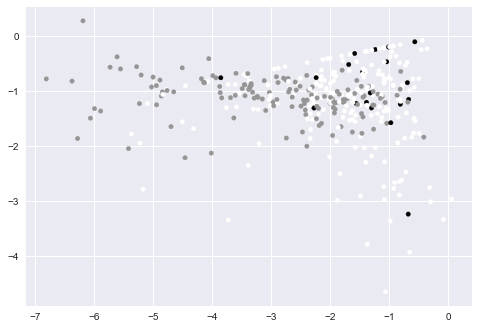

In [343]:
final_array = final_pandas["final_features"]
final_types = final_pandas["TYPE_INDEX"]
x = [item[0] if item[0] > -8 and item[1] > -6 else np.nan for item in final_array]
y = [item[1] if item[0] > -8 and item[1] > -6 else np.nan for item in final_array]

targets = final_pandas["TYPE_INDEX"].unique()

plt.scatter(x, y, c = final_types, s = 20)

#### Discussion

**Explain your code and discuss results**

## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [399]:
from graphframes import *
from graphframes.examples import Graphs
from pyspark import *
from pyspark.sql import *

In [366]:
originsDistinct = spark.sql("SELECT DISTINCT ORIGIN AS AIRPORT FROM flights LIMIT 100")
destinationsDistinct = spark.sql("SELECT DISTINCT DEST AS AIRPORT FROM flights LIMIT 100")
flightsDistinct = spark.sql("SELECT DISTINCT (ORIGIN, DEST) AS AIRPORT FROM flights LIMIT 100")
airportsDistinct = originsDistinct.union(destinationsDistinct).dropDuplicates()
airportsDistinct.show()

+-------+
|AIRPORT|
+-------+
|    BGM|
|    DLG|
|    PSE|
|    INL|
|    MSY|
|    PPG|
|    GEG|
|    DRT|
|    BUR|
|    SNA|
|    GRB|
|    GTF|
|    IFP|
|    IDA|
|    GRR|
|    LWB|
|    JLN|
|    PVU|
|    PSG|
|    EUG|
+-------+
only showing top 20 rows



In [367]:
flightsDistinct.show()

+----------+
|   AIRPORT|
+----------+
|{MCI, IAH}|
|{ROC, CLE}|
|{SNA, PHX}|
|{SPI, ORD}|
|{ATL, GSP}|
|{BQN, MCO}|
|{EWR, STT}|
|{FSD, ATL}|
|{MLI, MCO}|
|{PHL, MCO}|
|{LAX, OXR}|
|{ORD, PDX}|
|{PBI, DCA}|
|{LAS, LIT}|
|{SMF, BUR}|
|{CLE, SJU}|
|{AMA, MEM}|
|{DSM, MCO}|
|{TYS, MIA}|
|{MCI, MKE}|
+----------+
only showing top 20 rows



In [402]:
g = GraphFrame(airportsDistinct, flightsDistinct)

Py4JJavaError: An error occurred while calling o15486.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:471)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:588)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:521)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


#### Discussion

**Explain your code and discuss results**